In [1]:
directory = '/storage/GOES/orthorectified/Fog2022/*.nc'
!ls {directory}


/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20221820001177_e20221820003550_c20221820006401_o.nc
/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20221820006177_e20221820008550_c20221820012114_o.nc
/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20221820011177_e20221820013550_c20221820016263_o.nc
/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440001177_e20222440003550_c20222440007138_o.nc
/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440006177_e20222440008550_c20222440012442_o.nc
/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440011177_e20222440013550_c20222440016458_o.nc
/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440016177_e20222440018550_c20222440022143_o.nc
/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440021177_e20222440023550_c20222440026597_o.nc
/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440026177_e20222440028550_c202

In [2]:
import glob

imageList = glob.glob(directory)
imageList[1]

'/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440006177_e20222440008550_c20222440012442_o.nc'

In [3]:
len(imageList)

1467

In [4]:
ls -lah '/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440001177_e20222440003550_c20222440007138_o.nc'


-rw-rw-r--. 1 spestana spestana 0 Jun 21 13:31 /storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20222440001177_e20222440003550_c20222440007138_o.nc


In [6]:
bounds = (-123.7, 48.4, -122.7, 48.8)

In [7]:
import rioxarray as rix
ds = rix.open_rasterio(imageList[1])
ds = ds.rio.write_crs("EPSG:4326") # Set the coordinate reference system to latitude-longitude
ds = ds.rio.clip_box(*bounds) # Clip the image by the lat-lon bounds specified bove

In [10]:
ds.rio.resolution() # spherical coordinates (arc seconds)

(0.010573500688852726, -0.010573500688852613)

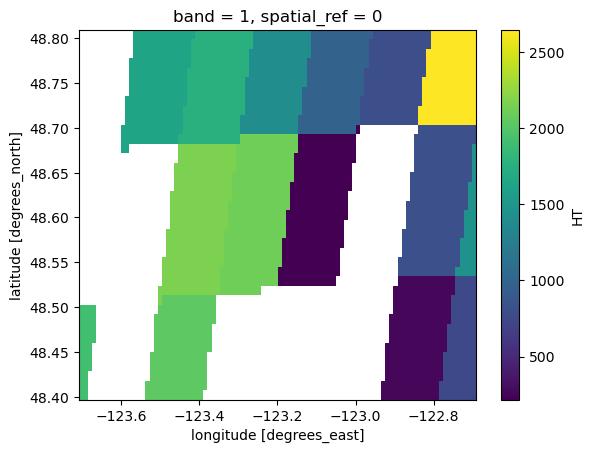

In [11]:
ds["HT"].plot()

In [12]:
ds["fog_presence"] = ds["HT"] <= 400

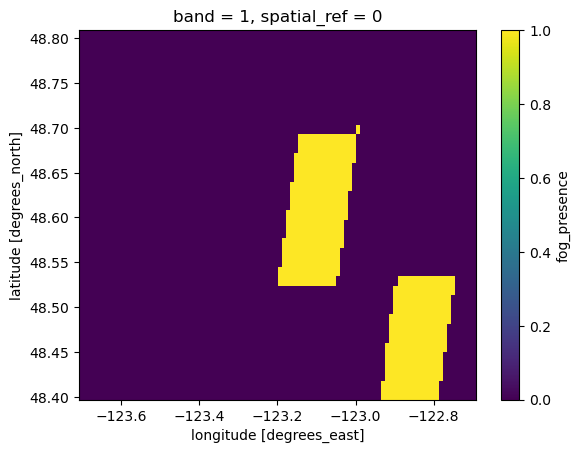

In [13]:
# (ds["elevation"] == 0).plot(cmap = "Greys")
ds["fog_presence"].plot()


In [50]:
import geopandas as gpd

In [51]:
shoreline = gpd.read_file("/storage/ngoc54n/us_medium_shoreline.shp")

In [52]:
shoreline["geometry"] = shoreline.clip_by_rect(*bounds)

In [53]:
shoreline = shoreline[~ shoreline["geometry"].is_empty]

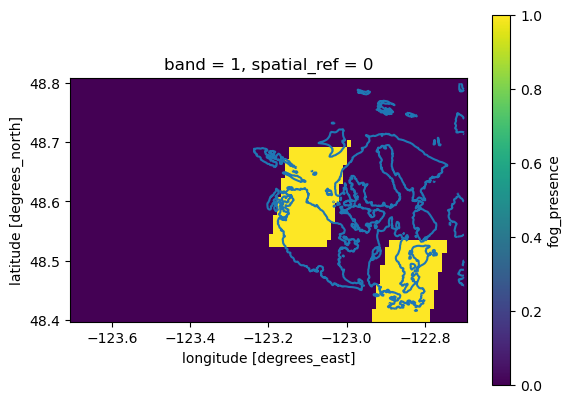

In [27]:
shoreline.plot()
ds["fog_presence"].plot()

### Stacking clipped images

In [62]:
# Path to an hour of 12 images
directory = '/storage/ngoc54n/GOES/orthorectified/Fog2022_clipped/*.nc'

In [63]:
import glob
imageList = glob.glob(directory)

In [14]:
len(imageList)

1467

In [64]:
from datetime import datetime
def parseDate(filename :str):
    # Get the part with time information in the string
    start_date_string = filename.split('_')[4]
    # Remove unnecessary characters
    start_date_string = start_date_string[1:-3]
    # Create a datetime object
    start_date_object = datetime.strptime(start_date_string, "%Y%j%H%M")

    # Do the same with the end date
    end_date_string = filename.split('_')[5]
    end_date_string = end_date_string[1:-3]
    end_date_object = datetime.strptime(end_date_string, "%Y%j%H%M")
    
    return start_date_object, end_date_object
    
parseDate('/storage/GOES/orthorectified/Fog2022/OR_ABI-L2-ACHAC-M6_G17_s20221820001609_e20221820003550_c20221820006401_o.nc')

(datetime.datetime(2022, 7, 1, 0, 3), datetime.datetime(2022, 7, 1, 0, 6))

In [66]:
import pandas as pd
import rioxarray as rix
import xarray as xr

list_ds = []

# Loop through each image in imageList
for imageName in imageList:
	# Get the end datetime object for the time that the observation of that image was finished
	imageDate = parseDate(imageName)[1]

	# Open the dataset from the image path
	ds = rix.open_rasterio(imageName)
	
	# ds = ds.drop_dims("band")

	ds = ds.assign_coords(time=imageDate)

	ds = ds.expand_dims(dim="time")

	list_ds.append(ds)

stack_ds = xr.combine_by_coords(list_ds)


In [67]:
stack_ds["fog_presence"] = stack_ds["HT"] <= 400

In [68]:
stack_fog = stack_ds.sel(band = 1)["fog_presence"]

In [69]:
frequency_array = stack_fog.sum(dim = 'time')/len(stack_fog["time"])

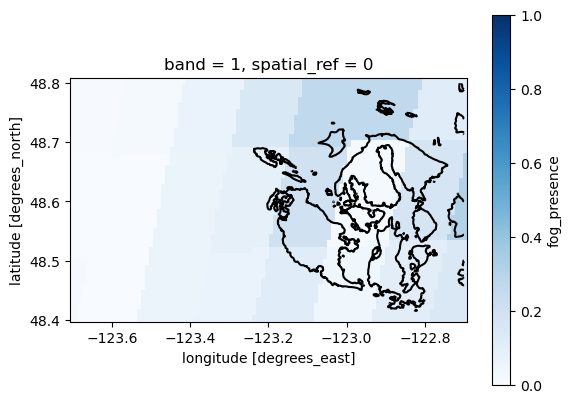

In [71]:
shoreline.plot(color = "Black")
frequency_array.plot(vmin = 0, vmax = 1,  alpha = 1, cmap = "Blues")
# xarray.plot() function wraps around matplotlib pcolormesh()